In [2]:
# find 5 closest objects or photo or spectra for the objects that were anomolous

In [4]:
import sys
sys.path.insert(0, '..')

import torch
import os
import wandb
import random
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from tqdm import tqdm
from matplotlib import cm
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.decomposition import PCA
from openTSNE import TSNE
from PIL import Image
import umap
import torch.nn.functional as F
from scipy.spatial.distance import cdist
import umap.plot
import math
from scipy.stats import norm
import joblib

from core.final.dataset import PSMDataset
from core.final.model import GalSpecNet, MetaModel, Informer, AstroModel
from core.final.trainer import Trainer

/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufu

In [5]:
def get_model(config):
    if config['mode'] == 'photo':
        model = Informer(config)
    elif config['mode'] == 'spectra':
        model = GalSpecNet(config)
    elif config['mode'] == 'meta':
        model = MetaModel(config)
    else:
        model = AstroModel(config)

    return model

def get_embs(dataloader):
    all_p_emb, all_s_emb, all_m_emb = [], [], []
    all_labels = []
    
    for photometry, photometry_mask, spectra, metadata, labels in tqdm(dataloader):
        photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
        spectra, metadata = spectra.to(device), metadata.to(device)
    
        with torch.no_grad():
            p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)
    
            all_p_emb.append(p_emb.cpu())
            all_s_emb.append(s_emb.cpu())
            all_m_emb.append(m_emb.cpu())
            all_labels.append(labels)
    
    all_p_emb = torch.vstack(all_p_emb)
    all_s_emb = torch.vstack(all_s_emb)
    all_m_emb = torch.vstack(all_m_emb)
    all_labels = torch.hstack(all_labels)

    return all_p_emb, all_s_emb, all_m_emb, all_labels

def get_centers(p_emb, s_emb, m_emb, train_labels):
    p_centers, s_centers, m_centers, all_centers = [], [], [], []

    for i in range(10):
        ind = train_labels == i
    
        p_center = p_emb[ind].mean(axis=0)
        p_center = p_center / p_center.norm()
        p_centers.append(p_center)
    
        s_center = s_emb[ind].mean(axis=0)
        s_center = s_center / s_center.norm()
        s_centers.append(s_center)
    
        m_center = m_emb[ind].mean(axis=0)
        m_center = m_center / m_center.norm()
        m_centers.append(m_center)

        all_emb = (p_emb + s_emb + m_emb) / 3
        all_center = all_emb[ind].mean(axis=0)
        all_center = all_center / all_center.norm()
        all_centers.append(all_center)
    
    p_centers = torch.stack(p_centers)
    s_centers = torch.stack(s_centers)
    m_centers = torch.stack(m_centers)
    all_centers = torch.stack(all_centers)

    return p_centers, s_centers, m_centers, all_centers

def plot_obj_umap(dataset, idx, embeddings, targets):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = el['org_period']
    l, b = id2lb[el['id']]
    
    photometry = dataset.get_vlc(el['name'])
    photometry = np.vstack(((photometry[:, 0] % period) / period, photometry[:, 1], photometry[:, 2])).T    # fold
    spectra = dataset.readLRSFits(os.path.join(dataset.lamost_spec_dir, el['spec_filename']))

    obj_embedding = embeddings[idx]
    
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    axs[0].plot(photometry[:, 0], photometry[:, 1], '.', label='Photometry')
    axs[1].plot(spectra[:, 0], spectra[:, 1], label='Spectra')
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = targets == class_id
        axs[2].scatter(embeddings[class_mask, 0], embeddings[class_mask, 1], 
                       color=palette[class_id], label=class_name, alpha=1.0, s=marker_size)

    axs[2].scatter(obj_embedding[0], obj_embedding[1], color=palette[targets[idx]], edgecolors='black', alpha=1.0, s=5 * marker_size)
    handles_colors = [mlines.Line2D([], [], color=palette[target2id[class_name]], marker='o', linestyle='None', markersize=8, 
                      label=class_name) for class_name in sorted_classes]
    axs[2].legend(handles=handles_colors, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10, title="Classes")
    
    
    plt.suptitle(f'period = {period}    label = {id2target[label]}     idx {idx}    L = {l}    B = {b}    id {el["id"]}')
    plt.tight_layout()
    plt.show()

In [6]:
org_train = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_train.csv')
org_val = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_val.csv')
org_test = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_test.csv')

org_train = org_train[['id', 'l', 'b']]
org_val = org_val[['id', 'l', 'b']]
org_test = org_test[['id', 'l', 'b']]

combined_df = pd.concat([org_train, org_val, org_test])
id2lb = combined_df.set_index('id')[['l', 'b']].T.to_dict('list')

In [8]:
run_id = 'MeriDK/AstroCLIPResults3/2wz4ysvn'
api = wandb.Api()
run = api.run(run_id)
config = run.config
config['use_wandb'] = False

model = get_model(config)
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

weights_path = os.path.join(config['weights_path'] + '-' + run_id.split('/')[-1], f'weights-best.pth')
model.load_state_dict(torch.load(weights_path, weights_only=False))

<All keys matched successfully>

In [9]:
config['file'] = 'preprocessed_data/sub50_lb/spectra_and_v'

train_dataset = PSMDataset(config, split='train')
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)

val_dataset = PSMDataset(config, split='val')
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

test_dataset = PSMDataset(config, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

train_p_emb, train_s_emb, train_m_emb, train_labels = get_embs(train_dataloader)
val_p_emb, val_s_emb, val_m_emb, val_labels = get_embs(val_dataloader)
test_p_emb, test_s_emb, test_m_emb, test_labels = get_embs(test_dataloader)

p_centers, s_centers, m_centers, all_centers = get_centers(train_p_emb, train_s_emb, train_m_emb, train_labels)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.83s/it]


In [10]:
train_emb = (train_p_emb + train_s_emb + train_m_emb) / 3
val_emb = (val_p_emb + val_s_emb + val_m_emb) / 3
test_emb = (test_p_emb + test_s_emb + test_m_emb) / 3

In [11]:
umap = joblib.load('umap.pkl')
train_umap = umap.transform(train_emb)
val_umap = umap.transform(val_emb)
test_umap = umap.transform(test_emb)

In [13]:
class_freq = test_dataset.df['target'].value_counts()
sorted_classes = class_freq.index

id2target = test_dataset.id2target
target2id = test_dataset.target2id

palette = sns.color_palette("Spectral", len(id2target))
palette[3], palette[-4] = palette[-4], palette[3] 
palette[1], palette[-2] = palette[-2], palette[1] 
marker_size = 12

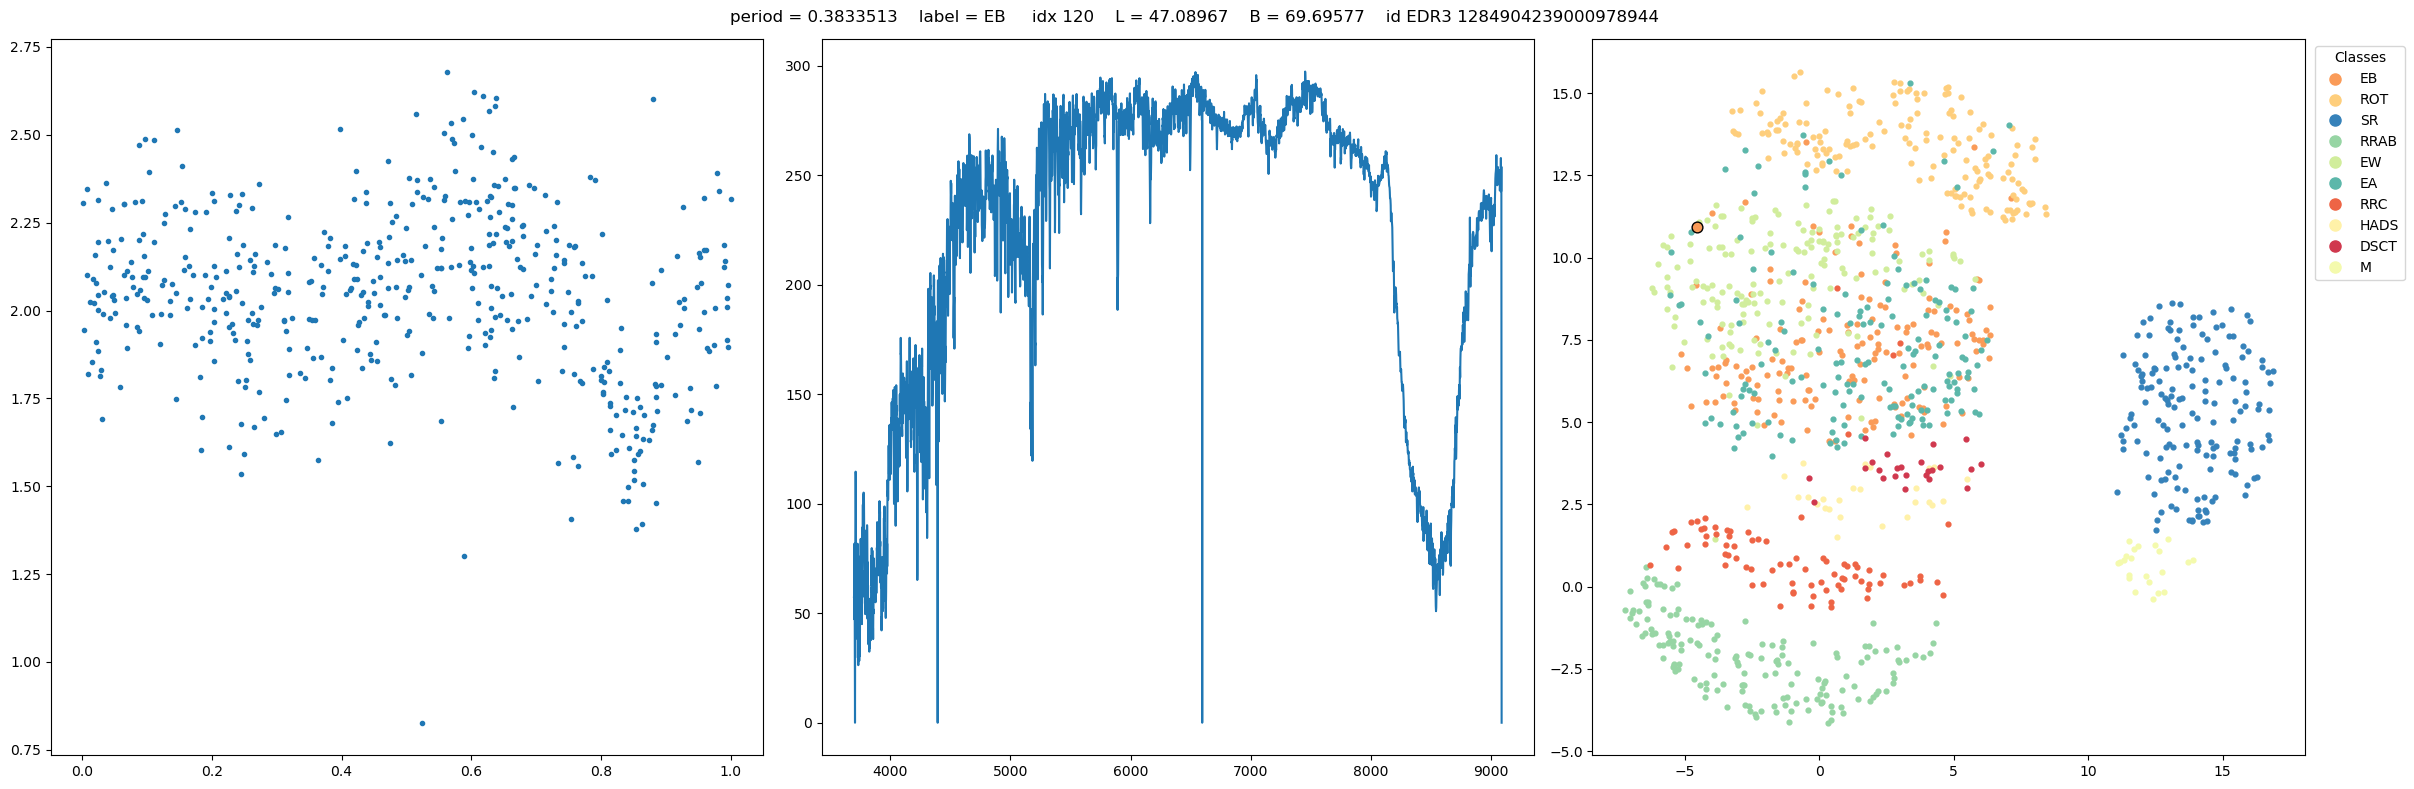

In [14]:
plot_obj_umap(test_dataset, 120, test_umap, test_labels)

In [21]:
p_emb = torch.vstack([train_p_emb, val_p_emb, test_p_emb])
s_emb = torch.vstack([train_s_emb, val_s_emb, test_s_emb])
m_emb = torch.vstack([train_m_emb, val_m_emb, test_m_emb])

In [27]:
def get_idx_ds(index):
    if index < len(train_dataset):
        return 'train', index
    elif len(train_dataset) <= index < len(train_dataset) + len(val_dataset):
        return 'val', index - len(train_dataset)
    else:
        return 'test', index - len(train_dataset) - len(val_dataset)

In [33]:
res = []

for el in torch.topk(test_s_emb[120] @ s_emb.T, 6).indices:
    split, idx = get_idx_ds(el.item())
    res.append((split, idx))
    print(el.item(), split, idx)

9717 test 120
2128 train 2128
1508 train 1508
8386 train 8386
10108 test 511
6256 train 6256


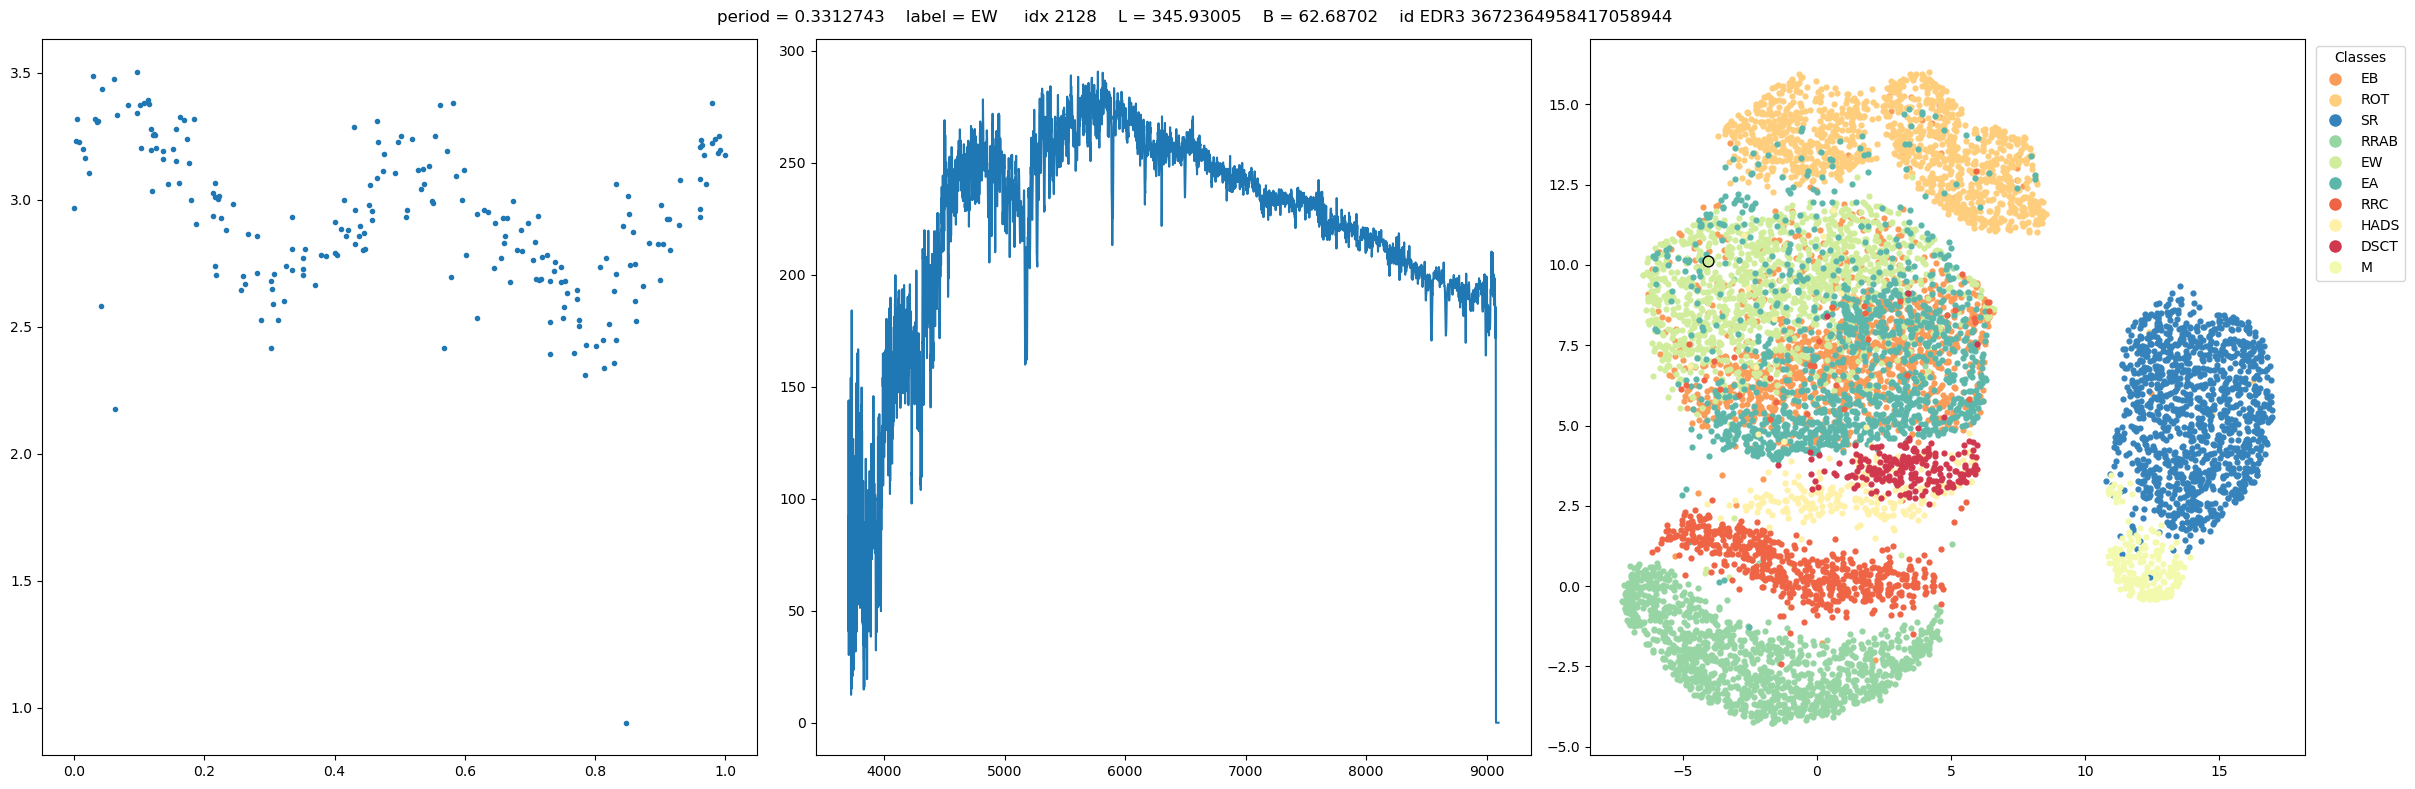

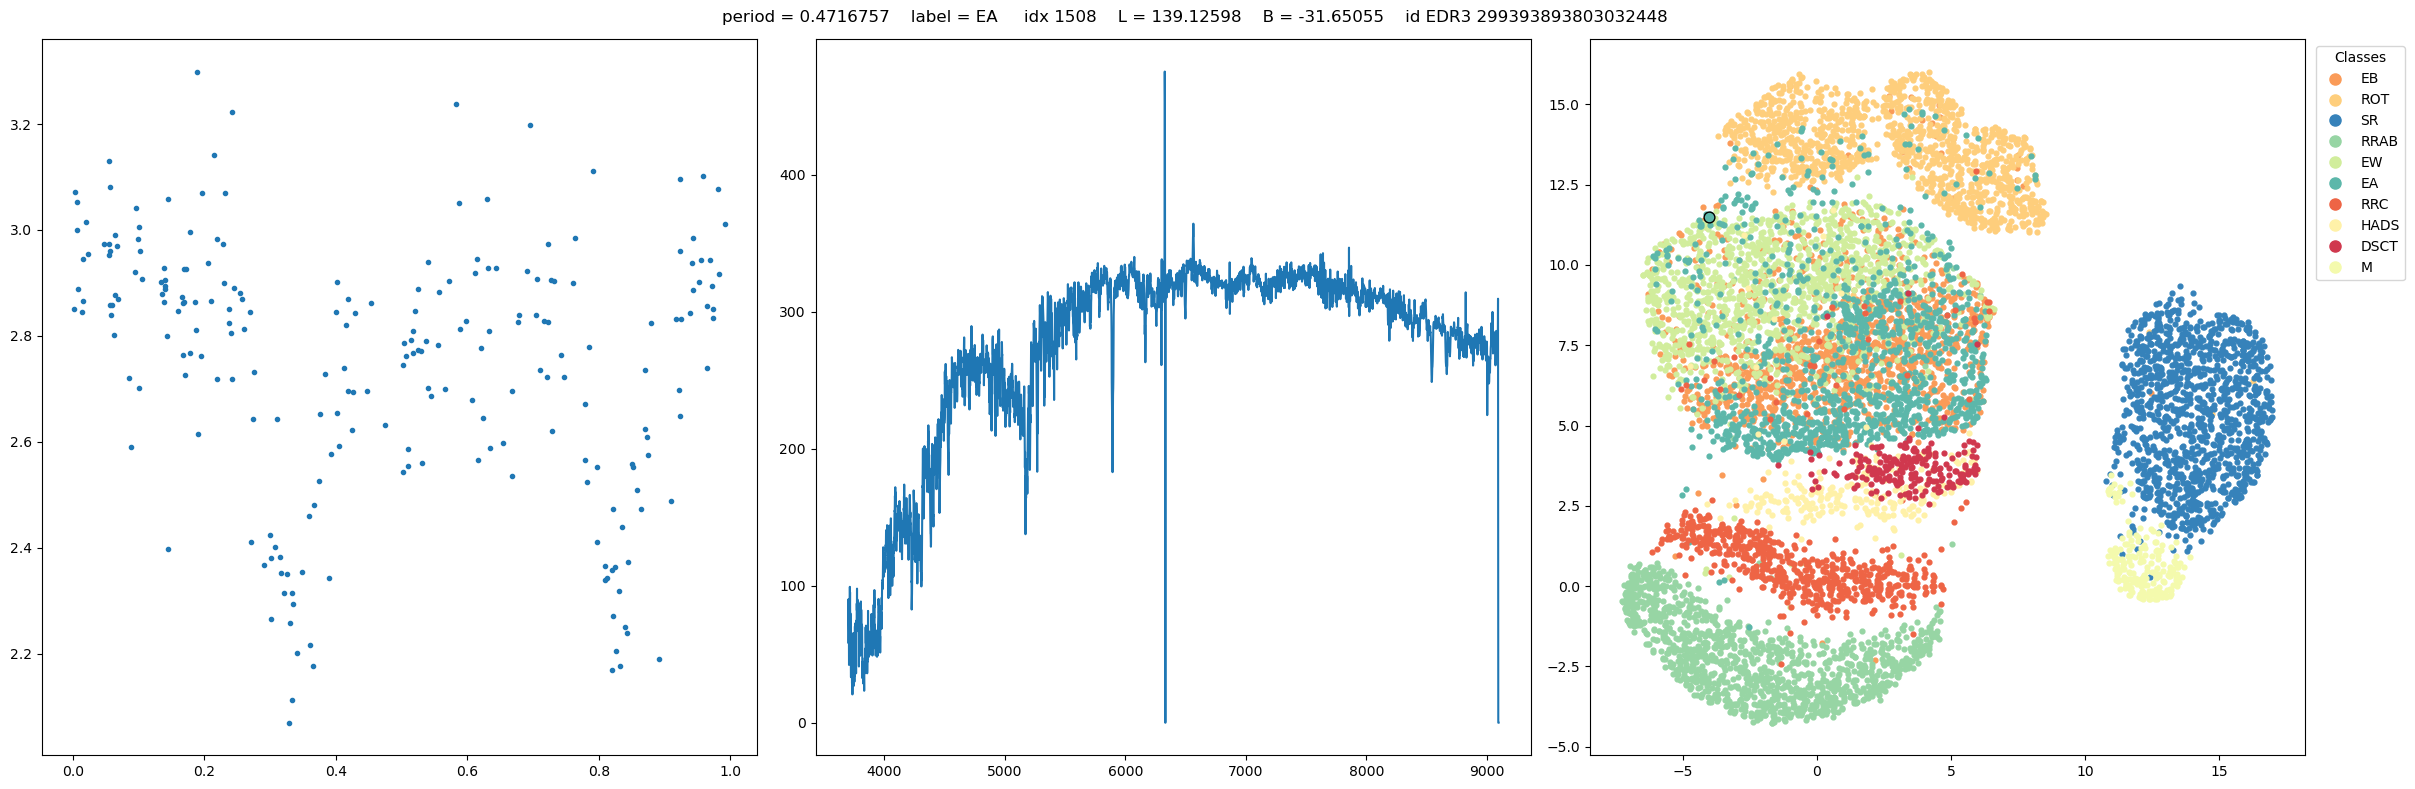

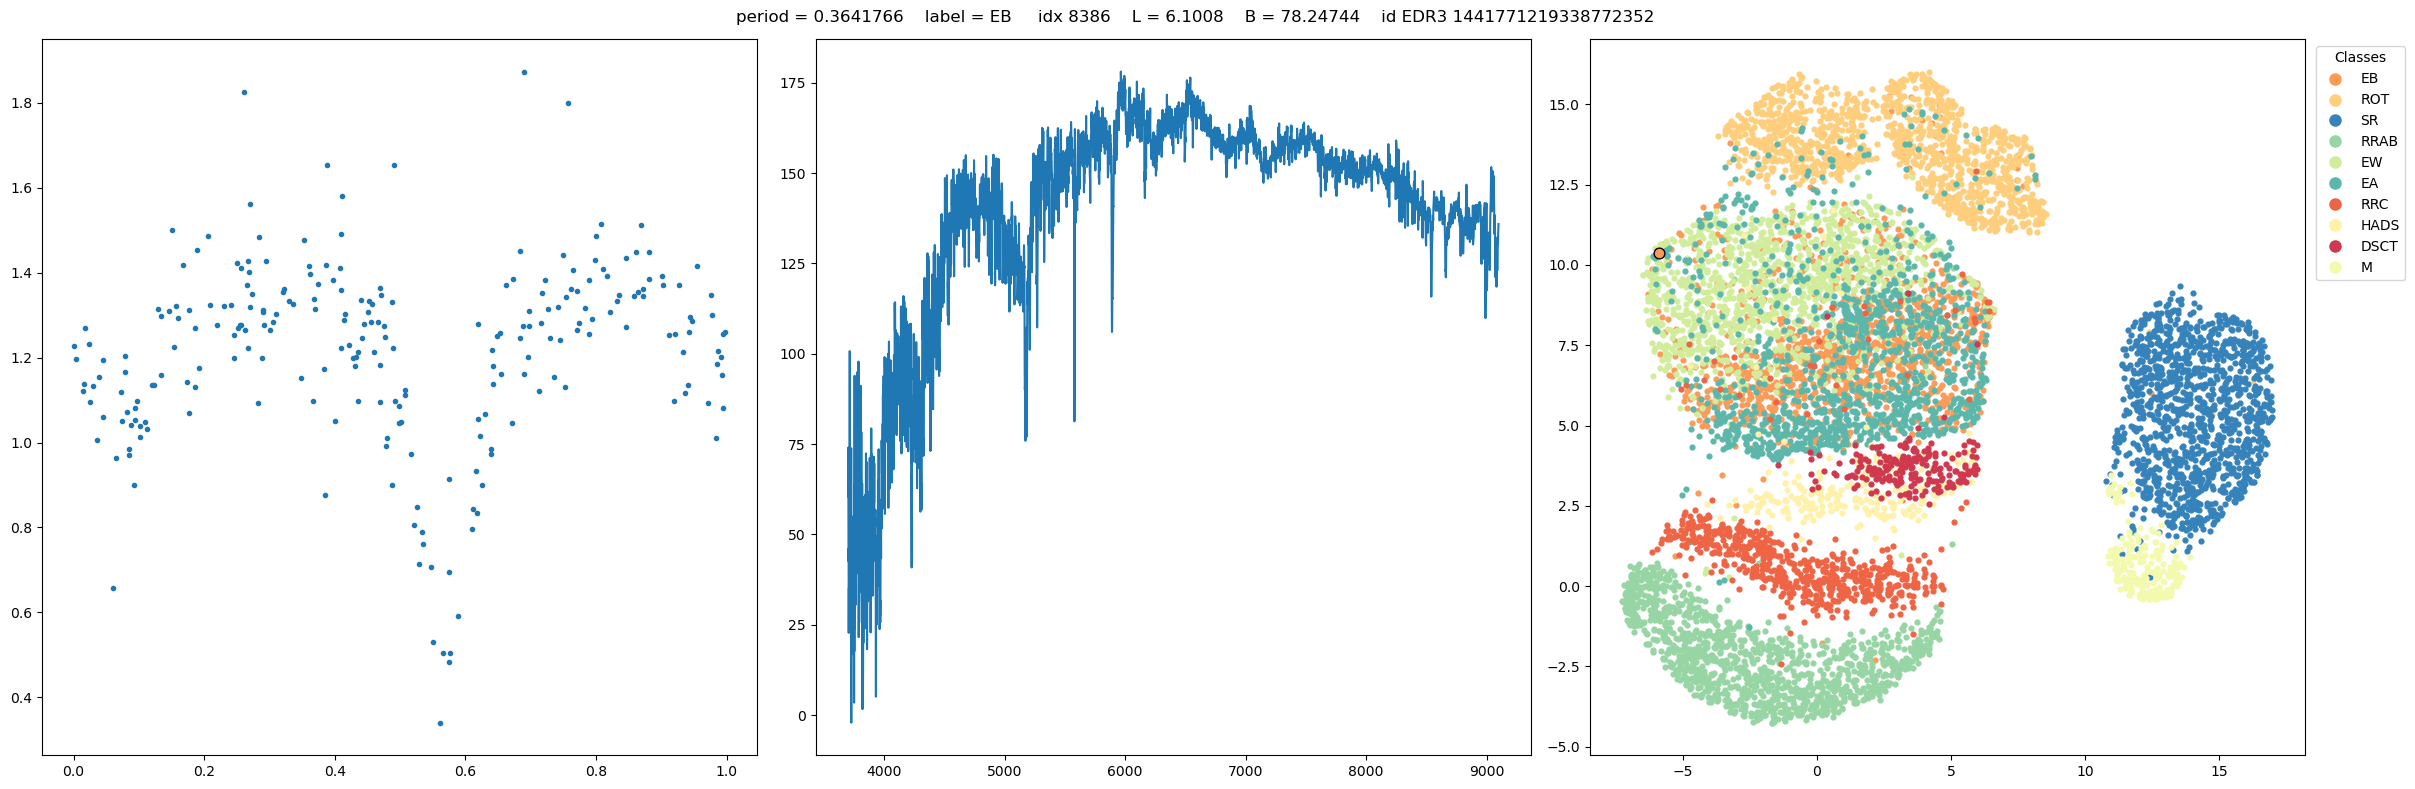

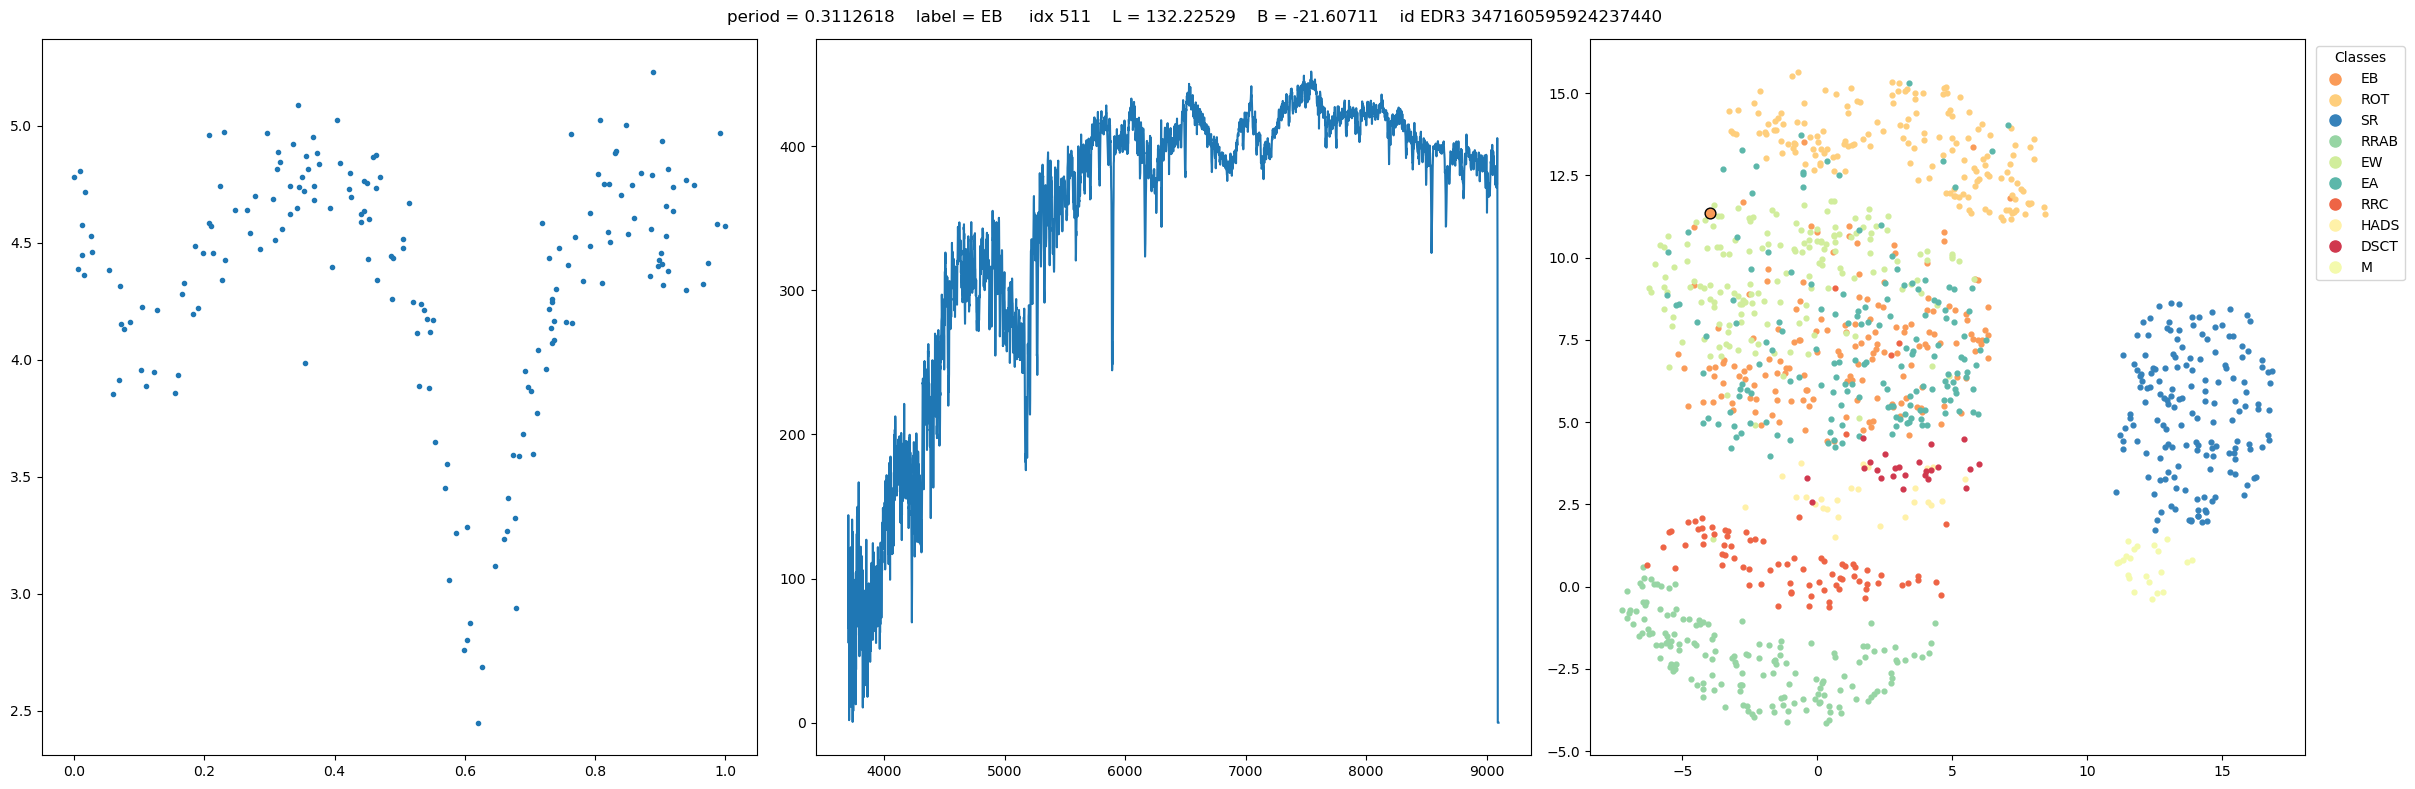

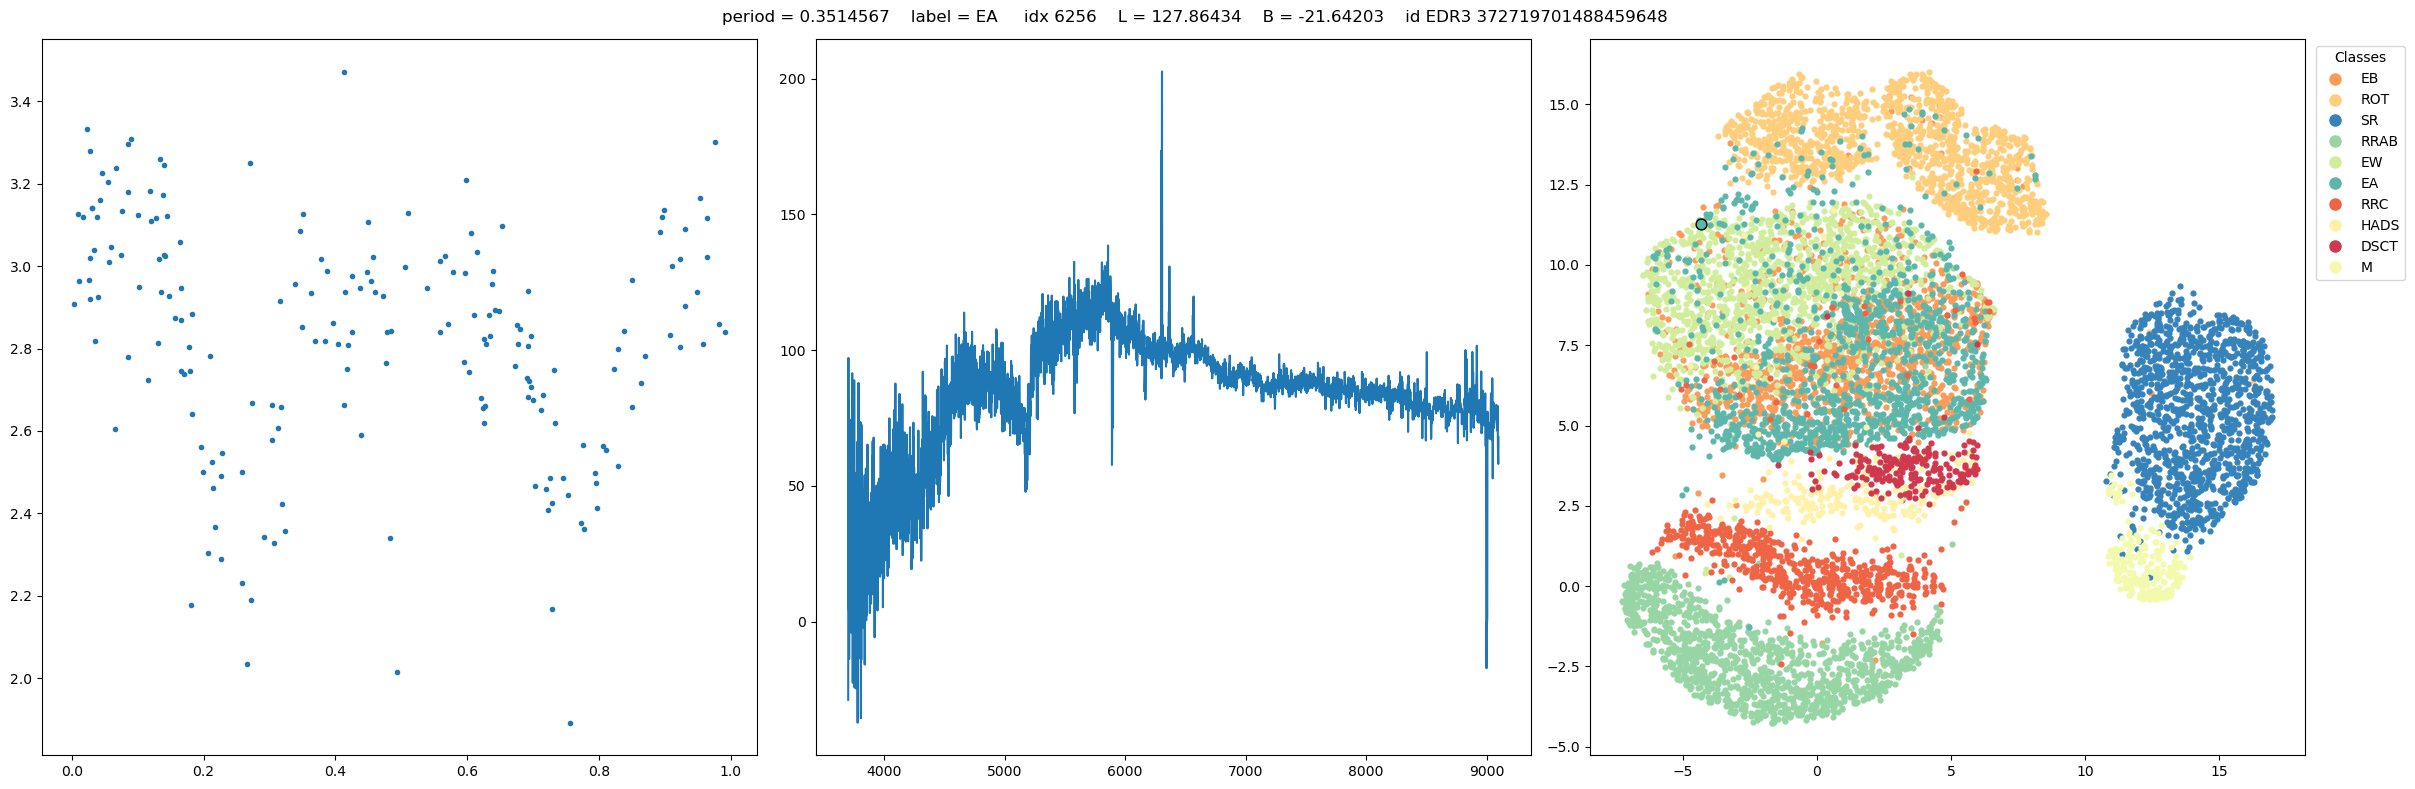

In [34]:
for split, idx in res[1:]:
    if split == 'train':
        plot_obj_umap(train_dataset, idx, train_umap, train_labels)
    elif split == 'val':
        plot_obj_umap(val_dataset, idx, val_umap, val_labels)
    else:
        plot_obj_umap(test_dataset, idx, test_umap, test_labels)

In [35]:
res = []

for el in torch.topk(test_p_emb[120] @ p_emb.T, 6).indices:
    split, idx = get_idx_ds(el.item())
    res.append((split, idx))
    print(el.item(), split, idx)

9717 test 120
3275 train 3275
8907 val 381
5078 train 5078
6363 train 6363
2900 train 2900


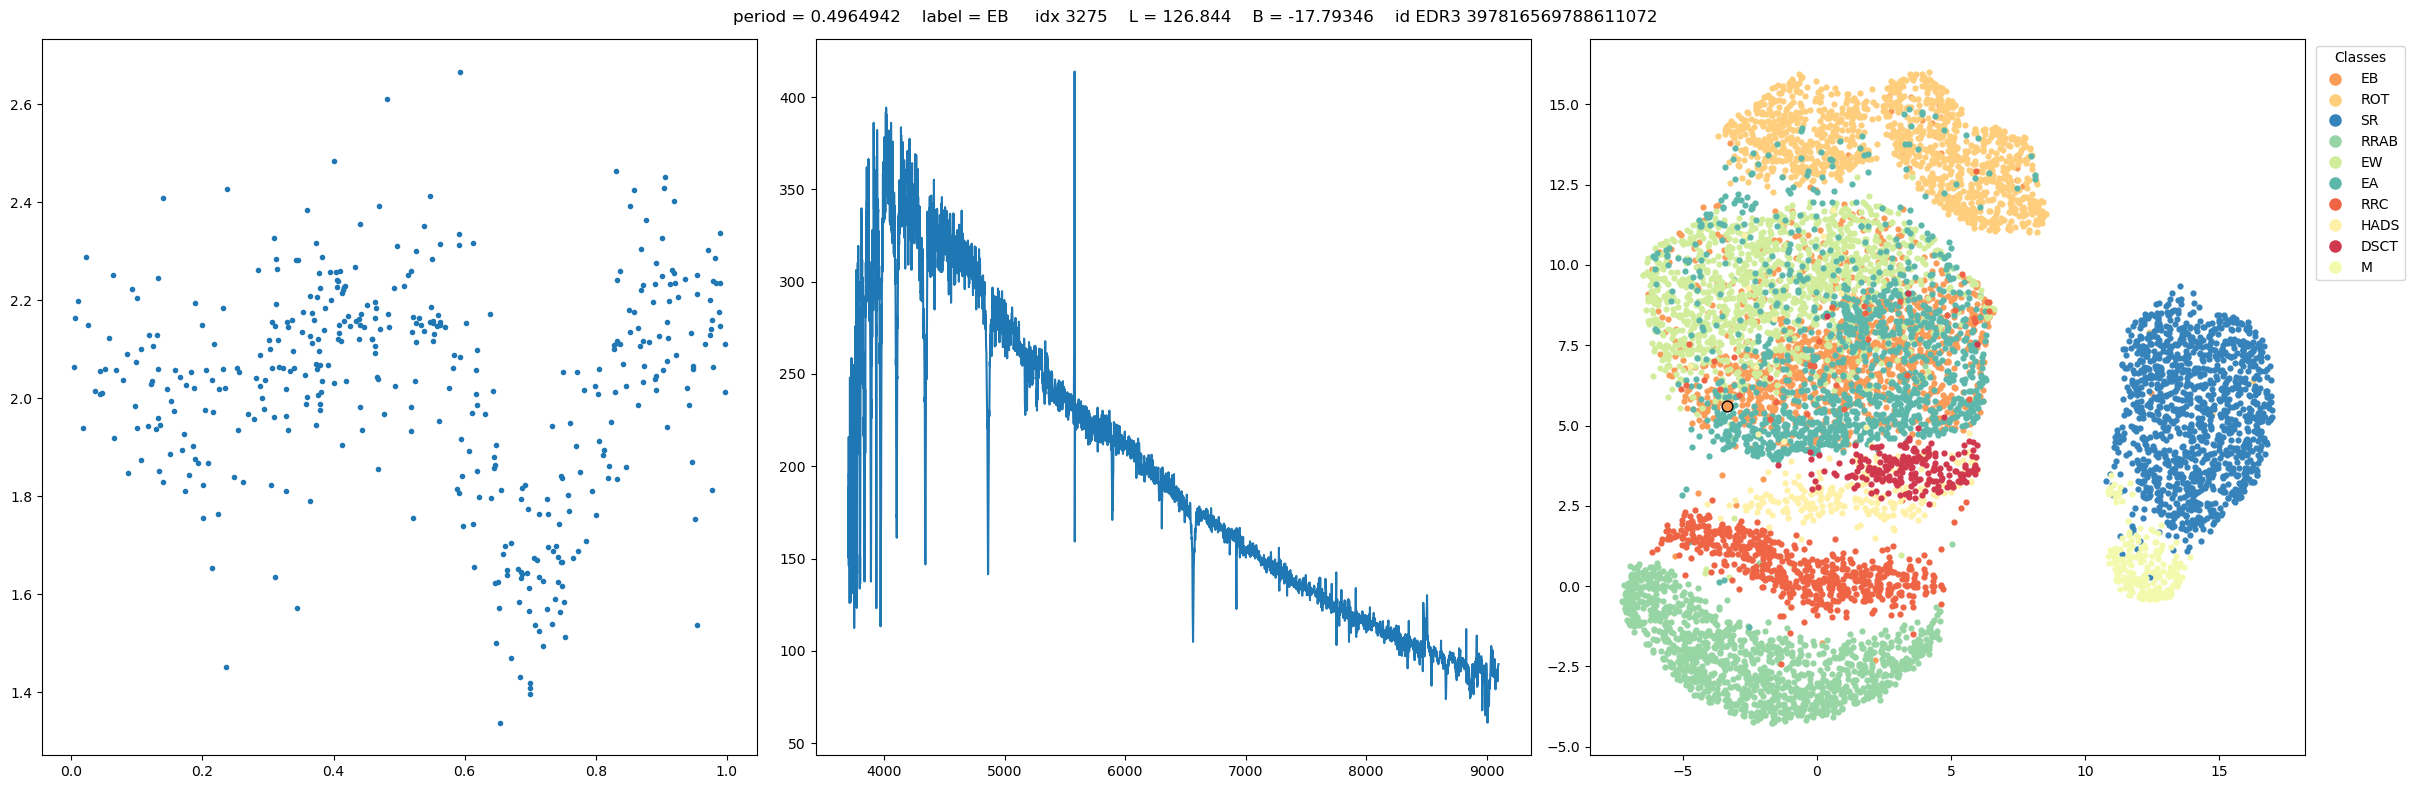

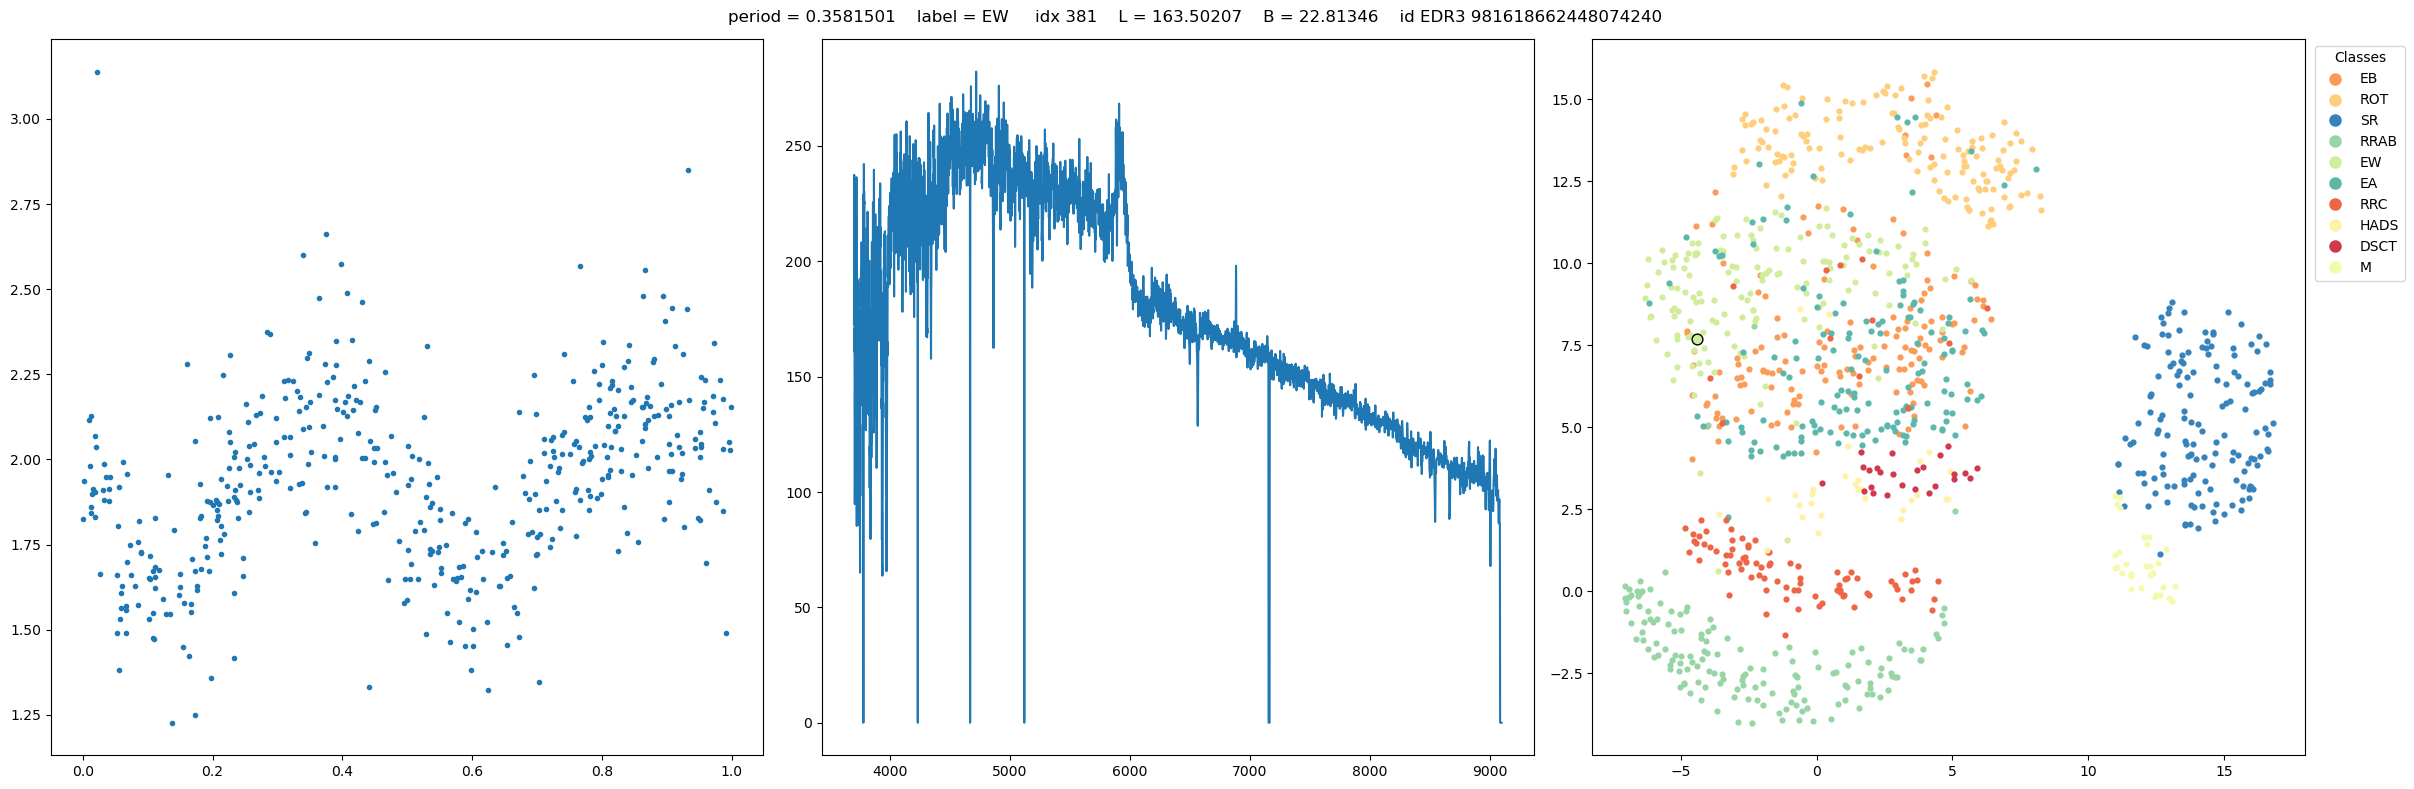

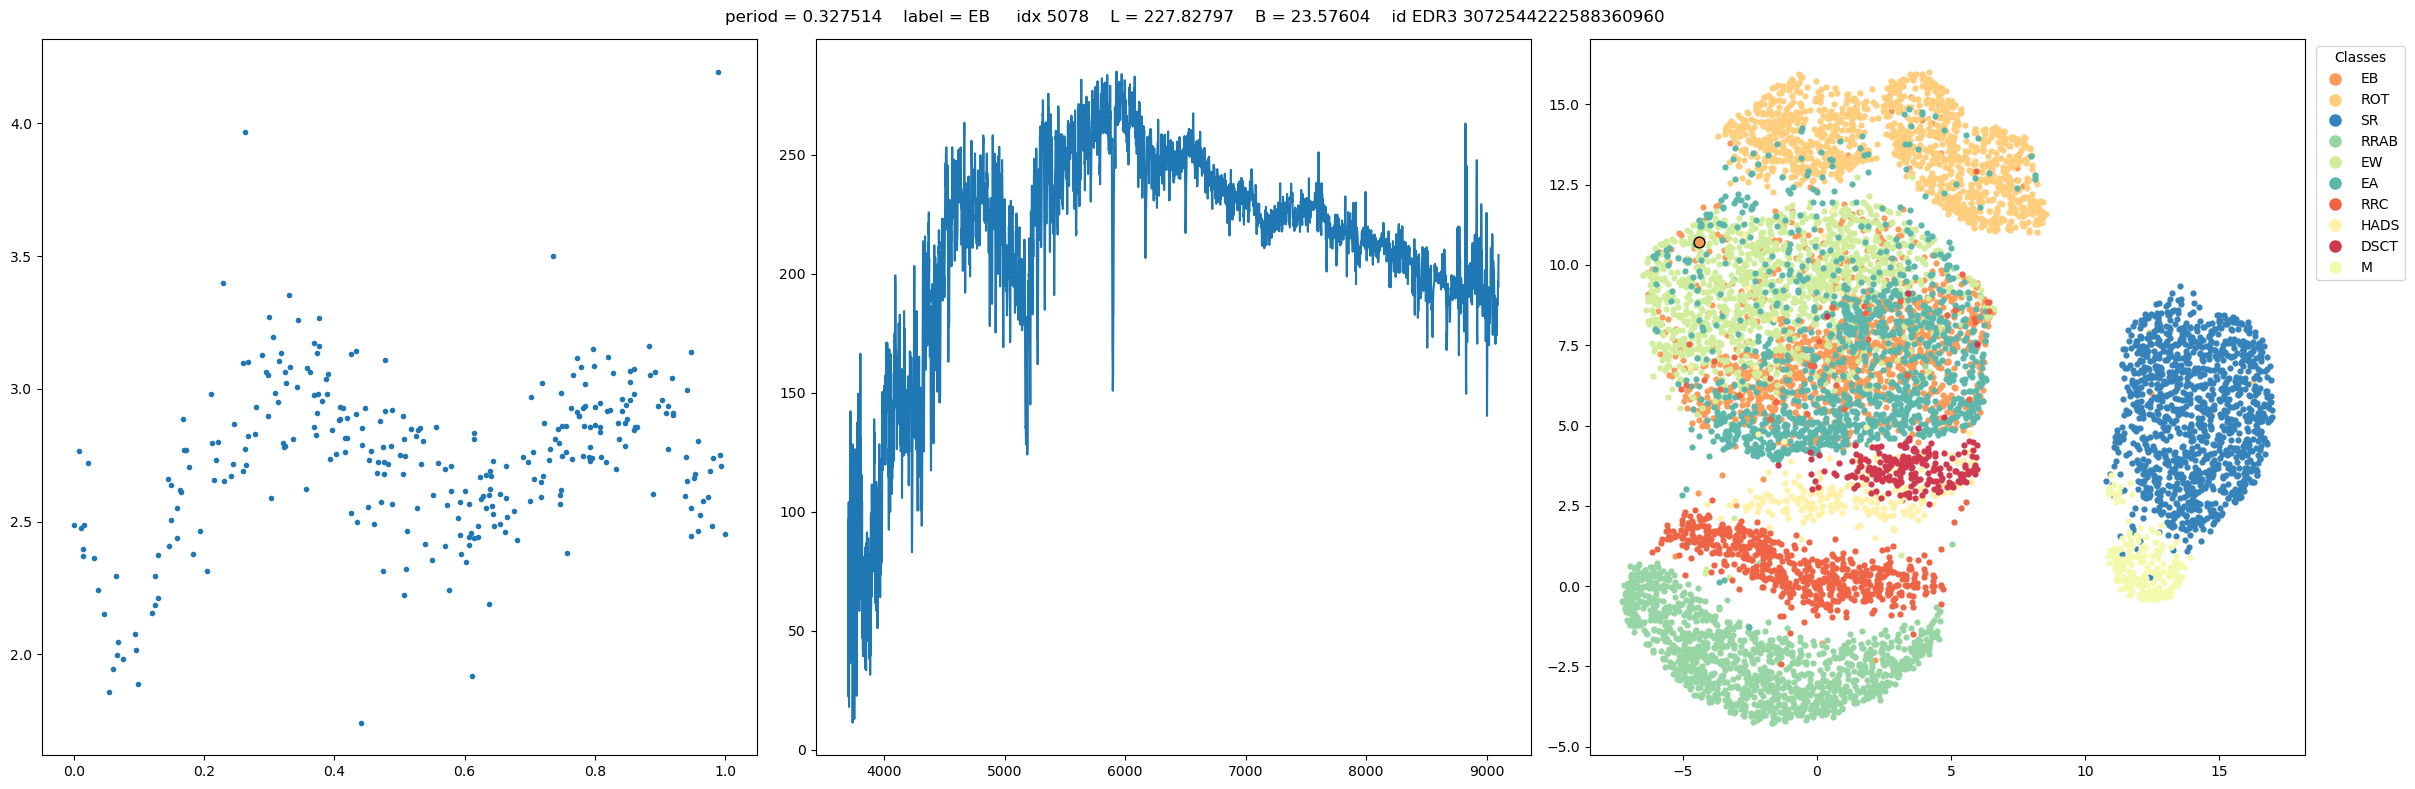

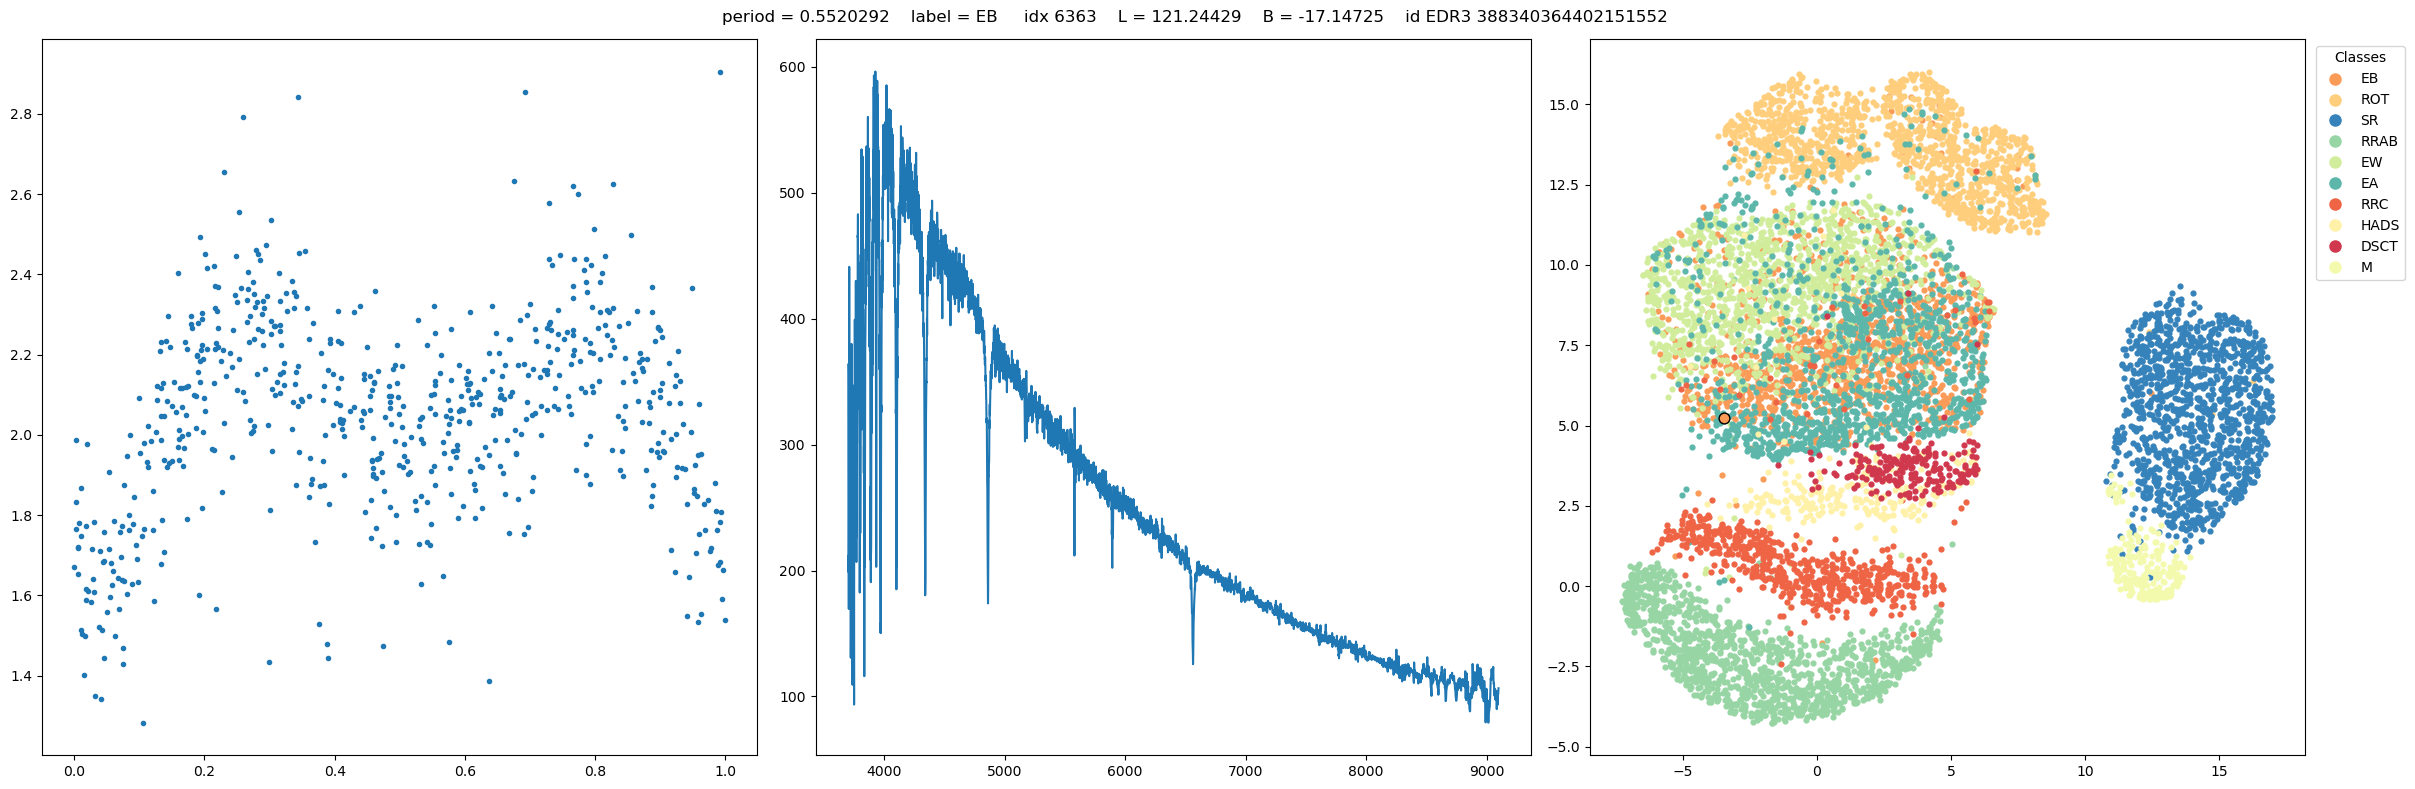

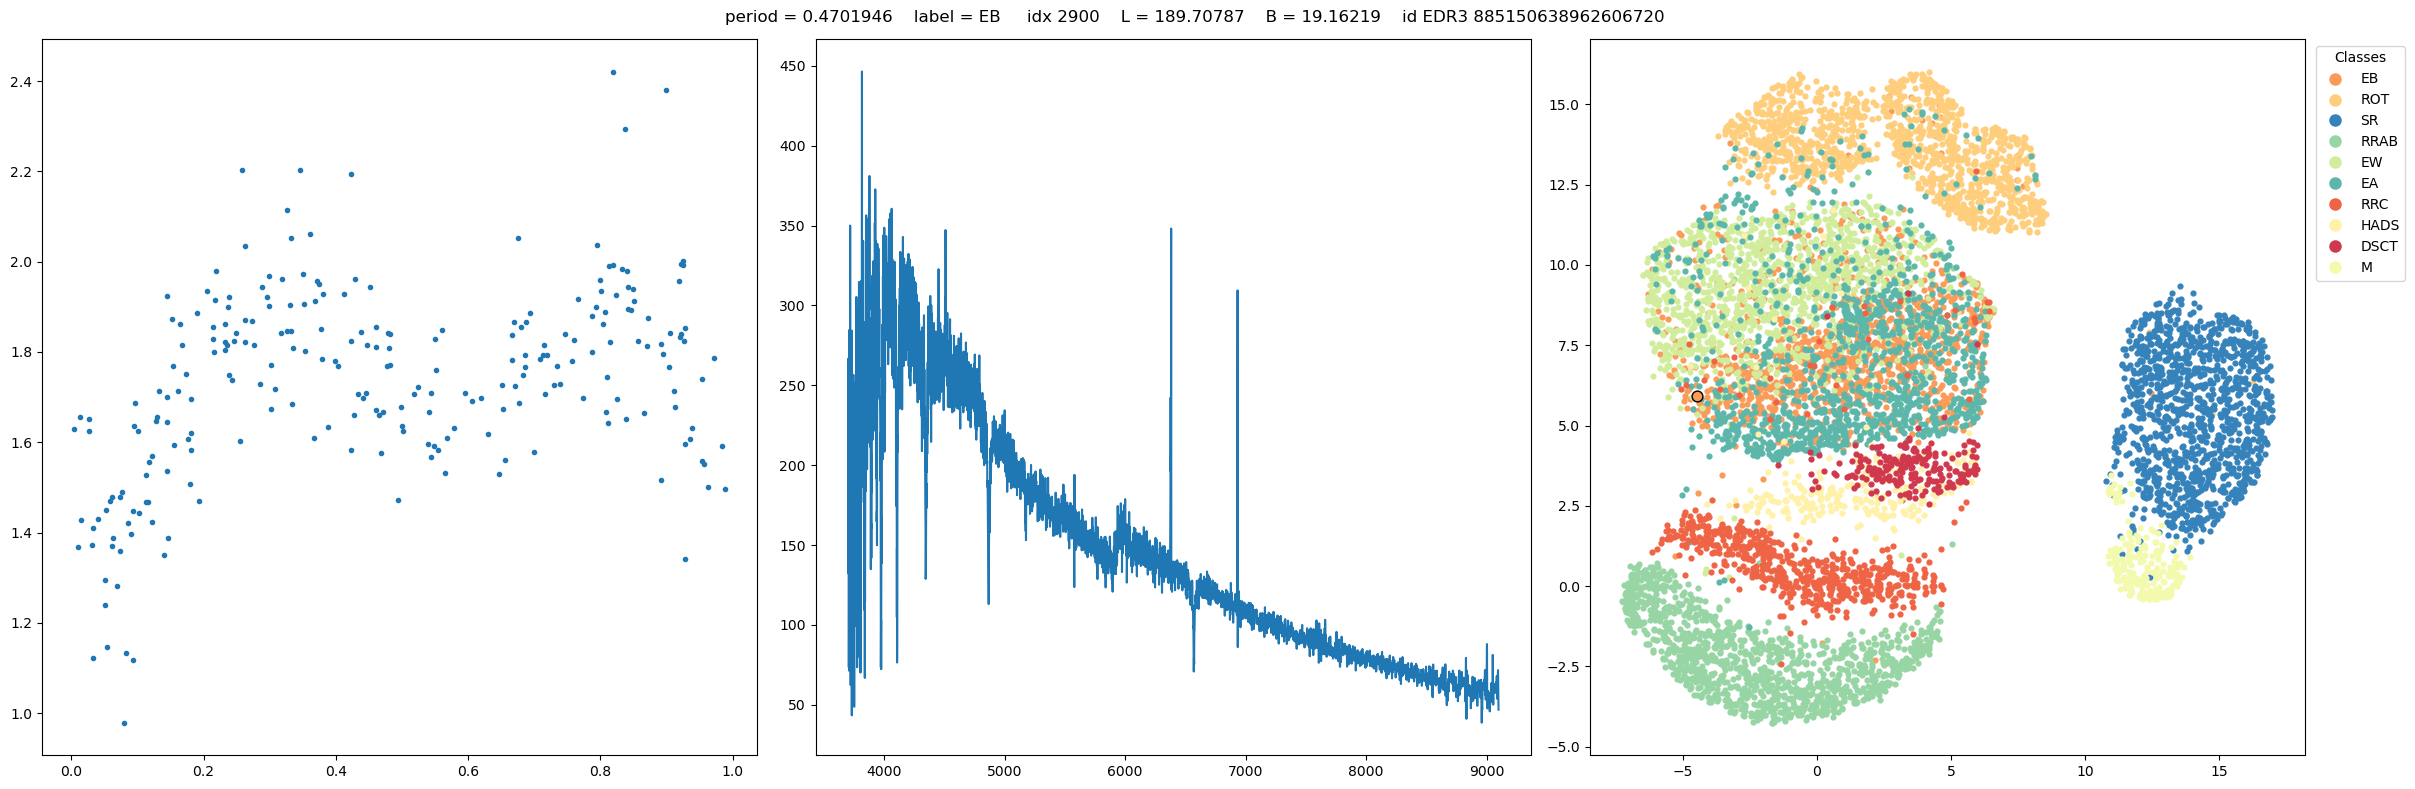

In [36]:
for split, idx in res[1:]:
    if split == 'train':
        plot_obj_umap(train_dataset, idx, train_umap, train_labels)
    elif split == 'val':
        plot_obj_umap(val_dataset, idx, val_umap, val_labels)
    else:
        plot_obj_umap(test_dataset, idx, test_umap, test_labels)